# Data Load

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import shutil
import zipfile

In [2]:
!pip install keras_cv_attention_models -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.3/796.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.9 MB/s eta 0:00:00


In [3]:
root_dir = "/content/"
zip_dir = root_dir + "drive/MyDrive/tensorflow/low_resolution_bird_image/"
data_dir = root_dir + "data/"

Data 압축 해제

In [4]:
# if os.path.exists(data_dir):
#   shutil.rmtree(root_dir + "data")

if not os.path.exists(data_dir):
  with zipfile.ZipFile(zip_dir + "open.zip",'r') as file:
    file.extractall(root_dir + "data")

In [5]:
rd_state = 29901
lr_w , lr_h = 64,64   # low resolution Image size
hr_w , hr_h = 256,256   # hight resolution image size

Image Data Generator

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

df_path = pd.read_csv(zip_dir+"data/" + "train.csv")

ohe = OneHotEncoder(sparse_output=False)
ohe.fit(np.array(df_path[["label"]]).reshape(-1,1))
classes = ohe.categories_[0]

print(df_path.head(2))

def get_image_generator(indexs=range(len(df_path))):
  for i in indexs:
    tr_img = cv2.imread(data_dir + df_path.iloc[i].img_path[2:])
    tr_img = cv2.cvtColor(tr_img,cv2.COLOR_BGR2RGB)
    tr_img = np.array(tr_img)

    label = ohe.transform([[df_path.iloc[i]["label"]]])[0]
    label = np.array(label)

    yield (tr_img , label)

n_split=10
skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=rd_state)

train_sets = []
test_sets = []
batch_size = 32

for i, (train_idx,test_idx) in enumerate(skf.split(df_path.img_path,df_path.label)):
  train_set = tf.data.Dataset.from_generator(get_image_generator,
                                             output_signature=(tf.TensorSpec(shape=(None,None,3),dtype=tf.float32),
                                                               tf.TensorSpec(shape=(25),dtype=tf.float32)),
                                             args=([train_idx]))
  test_set = tf.data.Dataset.from_generator(get_image_generator,
                                            output_signature=(tf.TensorSpec(shape=(None,None,3),dtype=tf.float32),
                                                              tf.TensorSpec(shape=(25),dtype=tf.float32)),
                                            args=([test_idx]))

  train_sets.append(train_set.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE))
  test_sets.append(test_set.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

ohe.transform([[df_path.iloc[0]["label"]]])[0]

                  img_path                 upscale_img_path           label
0  ./train/TRAIN_00000.jpg  ./upscale_train/TRAIN_00000.png  Ruddy Shelduck
1  ./train/TRAIN_00001.jpg  ./upscale_train/TRAIN_00001.png    Gray Wagtail


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0.])

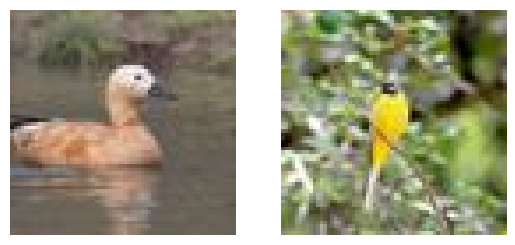

In [7]:
import matplotlib.pyplot as plt

imgen = get_image_generator()

fig,ax = plt.subplots(1,2)
imgs = next(imgen)
ax[0].imshow(imgs[0])
ax[0].axis("off")
imgs = next(imgen)
ax[1].imshow(imgs[0])
ax[1].axis("off")

plt.show()

# EDA

In [8]:
print(tf.__version__)

import matplotlib.pyplot as plt
import seaborn as sns

2.15.0


이미지 확인

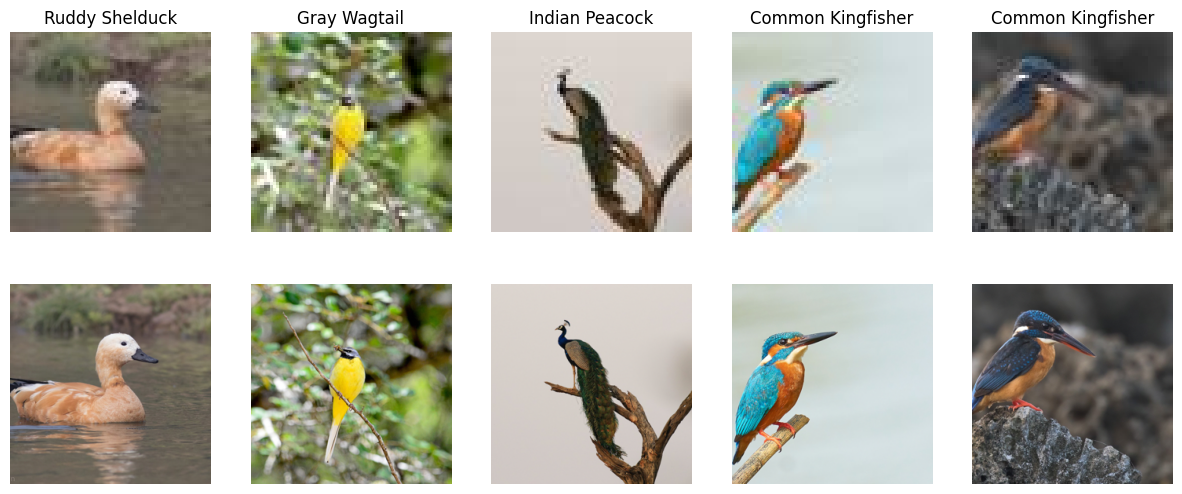

In [9]:
n=5
fig,ax = plt.subplots(2,n,figsize=(n*3,6))
for i,row in enumerate(df_path.itertuples()):
  if i == n:
    break

  tr_img = cv2.imread(data_dir + row.img_path[2:])
  tr_img = cv2.cvtColor(tr_img,cv2.COLOR_BGR2RGB)
  tr_img = np.array(tr_img)

  ax[0][i].imshow(tr_img)
  ax[0][i].axis("off")
  ax[0][i].set_title(row.label)

  lb_img = cv2.imread(data_dir + row.upscale_img_path[2:])
  lb_img = cv2.cvtColor(lb_img,cv2.COLOR_BGR2RGB)
  lb_img = np.array(lb_img)

  ax[1][i].imshow(lb_img)
  ax[1][i].axis("off")



Label 불균형 확인

<Axes: xlabel='count', ylabel='label'>

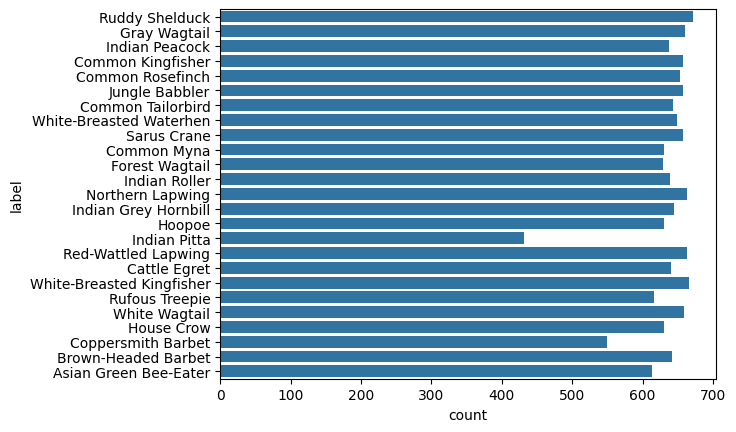

In [10]:
sns.countplot(df_path["label"])

# Classification

In [11]:
from tensorflow import keras
from tensorflow.keras import layers, Model, Input, losses,metrics, optimizers
from keras.applications import EfficientNetV2B2

In [12]:
from keras_cv_attention_models import swin_transformer_v2
base_model = swin_transformer_v2.SwinTransformerV2Tiny_window16(input_shape=(hr_w,hr_h,3),pretrained="imagenet",num_classes=0)
# from keras_cv_attention_models import efficientvit
# base_model = efficientvit.EfficientViT_B2(input_shape=(hr_w,hr_h,3),num_classes=0,pretrained="imagenet")

def image_aug():
  aug = keras.Sequential([
      layers.Resizing(256,256,interpolation="bicubic"),
      layers.Rescaling(scale=1./127.5,offset=-1),
      layers.RandomZoom(-0.2,0.2),
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(factor=0.02)
  ],
  name="image_augmenation",
  )
  return aug

def get_model():
  augmentation = image_aug()
  inputs = Input((lr_w,lr_h,3))

  out = augmentation(inputs)
  out = base_model(out)
  out = layers.GlobalAveragePooling2D()(out)
  # out = layers.Dropout(0.4)(out)
  out = layers.Dense(len(classes),kernel_regularizer=keras.regularizers.L2(0.01),activation="softmax")(out)

  return Model(inputs,out)

model = get_model()

model.summary()


114278296/114278296 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/swin_transformer_v2_tiny_window16_256_imagenet.h5
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 image_augmenation (Sequent  (None, 256, 256, 3)       0         
 ial)                                                            
                                                                 
 swin_transformer_v2_tiny_w  (None, 8, 8, 768)         27578154  
 indow16 (Functional)                                            
                                                                 
 global_average_pooling2d (  (None, 768)               0         
 GlobalAveragePooling2D)                                         
                             

In [14]:
import keras.backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

cp_path = root_dir+"cp.h5"

def scheduler(epoch,lr):
  return lr * 0.9

est = EarlyStopping(monitor = "val_loss",patience=3,mode="min")
rlr = ReduceLROnPlateau(monitor = "val_loss",factor=0.5,patience=1,min_lr=1e-5,cooldown=2)
mcp = ModelCheckpoint(cp_path,save_weights_only=True,monitor="val_loss",save_best_only=True)
lrs = LearningRateScheduler(scheduler)

model.compile(optimizer=optimizers.AdamW(2e-5),
              loss=losses.CategoricalFocalCrossentropy(),
              metrics=[
                  metrics.F1Score(average="macro")
              ])

for n in range(n_split):
  train_ds,val_ds = train_sets[n],test_sets[n]

  hist = model.fit(train_ds,validation_data=val_ds,epochs=50,verbose=1,callbacks=[est,rlr,mcp])
  break

  K.clear_session()

테스트 데이터 분

In [16]:
from tqdm import tqdm

model.load_weights(cp_path)
test_df = pd.read_csv(zip_dir+"data/" + "test.csv")

def get_pred(df = test_df):
  global pred
  images = []
  for i in tqdm(range(len(df))):
    img = cv2.imread(data_dir + df.iloc[i].img_path[2:])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)

  images = np.array(images)
  pred = model.predict(images,verbose=0)
  # pred = np.argmax(pred,axis=1)

  test_df["label"] = ohe.inverse_transform(pred).reshape(-1)

get_pred()

print(test_df)

In [ ]:
sns.countplot(test_df["label"])
plt.show()

Encoded Label 복호화

In [ ]:
test_df.drop("img_path",axis=1).to_csv(zip_dir+"sample_submission.csv",index=False)